# SD-TSIA-204: TP2


# Gabriele LORENZO


## Setup:


In [682]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [683]:
fn1 = "gabriele"
ln1 = "lorenzo"
filename = "_".join(map(lambda s: s.strip().lower(), ["SD-TSIA204_lab2", ln1, fn1]))

print(filename)

sd-tsia204_lab2_lorenzo_gabriele


## Q.1:

For the first question, we load a standard dataset from sklearn.datasets named
fetch_california_housing. This dataset has only p = 8 variables.


In [684]:
dataset = fetch_california_housing()
x, y = dataset.data, dataset.target

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=0
)

#### (a):

Estimate the coefficients with the expression of the normal equaitons seen in class. Code two functions to compute the MSE and the R2 coefficient and compare them with the version of sklearn for the train and the test sets.


We can write the normal equation as:
$$X^TX\hat{\theta}=X^TY$$

where $X$ is the design matrix and $y$ is the target vector.

The solution is given by:
$$\hat{\theta} = (X^TX)^{-1}X^Ty$$

We define the MSE and R2 functions as follows:

$$MSE = \frac{1}{n} \sum_i^n (y_i - \hat{y_i})^2$$
$$R^2 = 1 - \frac{\sum_i^n (y_i - \hat{y_i})^2}{\sum_i^n (y_i - \bar{y_i})^2}$$

In [685]:
def MSE(y, y_hat):
    return np.mean((y - y_hat) ** 2)


def R2(y, y_hat):
    return 1 - np.sum((y - y_hat) ** 2) / np.sum((y - np.mean(y)) ** 2)


df_res = pd.DataFrame(
    index=["MSE", "R2"], columns=["my implementation", "sklearn implementation"]
)

# my own implementation
# add bias column to x_train and x_test
x_train_bias = np.c_[np.ones(x_train.shape[0]), x_train]
x_test_bias = np.c_[np.ones(x_test.shape[0]), x_test]

theta = np.linalg.inv(x_train_bias.T @ x_train_bias) @ x_train_bias.T @ y_train
y_pred_1 = x_test_bias @ theta

df_res.loc["MSE", "my implementation"] = MSE(y_test, y_pred_1)
df_res.loc["R2", "my implementation"] = R2(y_test, y_pred_1)

# sklearn implementation
model = LinearRegression()
model.fit(x_train_bias, y_train)
y_pred_2 = model.predict(x_test_bias)

df_res.loc["MSE", "sklearn implementation"] = MSE(y_test, y_pred_2)
df_res.loc[
    "R2",
    "sklearn implementation",
] = R2(y_test, y_pred_2)

print(df_res)

    my implementation sklearn implementation
MSE          0.540413               0.540413
R2            0.59117                0.59117


#### (b):

Finally, give the confidence intervals at level 99% for all the coefficients coding the expression for the CI seen in session 3.


We can compute the confidence interval for the coefficients as follows:

$$
CI = \left[ \, \hat{\theta}_j - t_{1-\alpha/2}\hat{\sigma}\sqrt{(X^T X)^{-1}_{j,j}}, \,\,\, \hat{\theta}_j + t_{1-\alpha/2}\hat{\sigma}\sqrt{(X^T X)^{-1}_{j,j}} \, \right]
$$

where $t_{1 - \alpha / 2}$ is the quantile of the Student distribution with $n-p-1$ degrees of freedom and $1 - \alpha / 2$ quantile.

In [686]:
alpha = 0.01
n = x_train_bias.shape[0]
p = x_train_bias.shape[1]
deg_f = n - p - 1

t_crit = t.ppf(1 - alpha / 2, deg_f)

CI = np.zeros((p, 2))

sigma = np.sqrt(np.sum((y_train - x_train_bias @ theta) ** 2) / deg_f)

for i in range(p):
    s = np.sqrt(np.linalg.inv(x_train_bias.T @ x_train_bias)[i, i]) * sigma
    CI[i, 0] = theta[i] - t_crit * s
    CI[i, 1] = theta[i] + t_crit * s

df_CI = pd.DataFrame(
    index=["theta_{}".format(i) for i in range(p)],
    columns=["theta", "CI lower", "CI upper"],
)
df_CI["CI lower"] = CI[:, 0]
df_CI["CI upper"] = CI[:, 1]
df_CI["theta"] = theta
print(df_CI)

             theta   CI lower   CI upper
theta_0 -36.609594 -38.566103 -34.653084
theta_1   0.439091   0.426611   0.451571
theta_2   0.009599   0.008277   0.010920
theta_3  -0.103311  -0.120728  -0.085894
theta_4   0.616730   0.534395   0.699066
theta_5  -0.000008  -0.000022   0.000006
theta_6  -0.004488  -0.006743  -0.002234
theta_7  -0.417353  -0.438730  -0.395977
theta_8  -0.430614  -0.452995  -0.408234


## Q.2:

For the rest of the TP, we use the dataset in eCampus data. Load and preprocess the data:


#### (a):

Separate the data in train and test sets: save one fourth of the data as testing train_test_split from sklearn.model_selection with the random seed set to 0 and standardize both the training and testing sets using the fit_transform and transform functions in sklearn.preprocessing.StandardScaler.


In [688]:
df = pd.read_csv("./data/data.csv", sep=",", encoding="utf-8", header=None)

X, y = df.values[:, :-1], df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# reshape y from 1D array to 2D array
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

## fit the scaler (compute mean and std)
fit_X = StandardScaler().fit(X_train)
fit_y = StandardScaler().fit(y_train)

# standardize the data using the fitted scaler
X_train_scaled = fit_X.transform(X_train)
y_train_scaled = fit_y.transform(y_train).ravel()

X_test_scaled = fit_X.transform(X_test)
y_test_scaled = fit_y.transform(y_test).ravel()

#### (b):

Fit a regular OLS.


In [689]:
OLS = LinearRegression().fit(X_train_scaled, y_train_scaled)
y_pred = OLS.predict(X_test_scaled)

df_res = pd.DataFrame(index=["MSE", "R2"])

df_res.loc["MSE", "sklearn standardized"] = MSE(y_test_scaled, y_pred)
df_res.loc[
    "R2",
    "sklearn standardized",
] = R2(y_test_scaled, y_pred)

print(df_res)

     sklearn standardized
MSE              0.672812
R2               0.152485


## Q.3:

Program the method of forward variable selection based on hypothesis tests for regression coefficients. This method starts from an empty set of variables S and at each iteration selects one variable relevant for predicting y and includes it in the set S. It runs until a halting condition is met. The coding process is as follows:


#### (a):

Develop a function that, given a dataset $X \in \R^{n \times p}$ and $y$, fits $p$ linear regression models, each using only feature $X_j$ to predict $y$. For each model, conduct a test of no effect, as discussed in session 3, and compute the p-value of the test. This function should return the coefficient with the smallest p-value. Explain the significance of the p-value in this context.


Supposing we have a Gaussian model like the following:

$$y_i = \theta_0^{*} + \displaystyle\sum_{k=1}^p\theta_k^{*} x_{i,k} + \epsilon{_i}$$

We define the test of no-effect as:
$$\mathcal{H}_0 : \theta_j^{*} = 0$$


In [690]:
def test_no_effect(X_j, y):
    X_j = X_j.reshape(-1, 1)
    n, p = X_j.shape
    deg_f = n - p - 1

    theta = np.linalg.inv(X_j.T @ X_j) @ X_j.T @ y

    y_pred = X_j @ theta

    sigma = np.sqrt(np.sum((y - y_pred) ** 2) / deg_f)
    s = np.sqrt(np.linalg.inv(X_j.T @ X_j)[0, 0])

    t_stat = (theta) / (sigma * s)

    p_value = 2 * t.cdf(-np.abs(t_stat), deg_f)

    return p_value, theta

In [691]:
# foward variable selection
def fvs(X, y, plot=False):
    p = X.shape[1]
    selected_features = []
    best_p_values = []
    features = list(range(p))
    plt.figure(figsize=(25, 6))

    while len(features) > 0:
        p_values = []
        thetas = []

        for i in range(len(features)):
            X_j = X[:, i]
            p_values.append(test_no_effect(X_j, y)[0])
            thetas.append(test_no_effect(X_j, y)[1])

        if plot and len(best_p_values) < 6:
            plt.plot(
                range(len(features)), p_values, marker="o", linestyle="-"
            )

        if plot and len(best_p_values) == 6:
            plt.xlabel("Feature Index")
            plt.ylabel("p-value")
            plt.title("p-values of the first 5 coefficients")
            plt.grid(True)
            plt.legend(
                ["1st iteration", "2nd iteration", "3rd iteration",
                    "4th iteration", "5th iteration"],
                loc="upper right",
                bbox_to_anchor=(1.1, 1.05),
            )
            plt.show()

        if np.min(p_values) > 0.05:
            break

        # get the index of the feature with the smallest p-value
        idx = np.where(p_values == np.min(p_values))[0][0]

        selected_features.append(features[idx])
        best_p_values.append(p_values[idx])

        features.pop(idx)

        # remove the effect of the selected feature
        y -= X[:, idx] * thetas[idx]

        # remove the selected feature from X
        X = np.delete(X, idx, axis=1)

    return selected_features, best_p_values

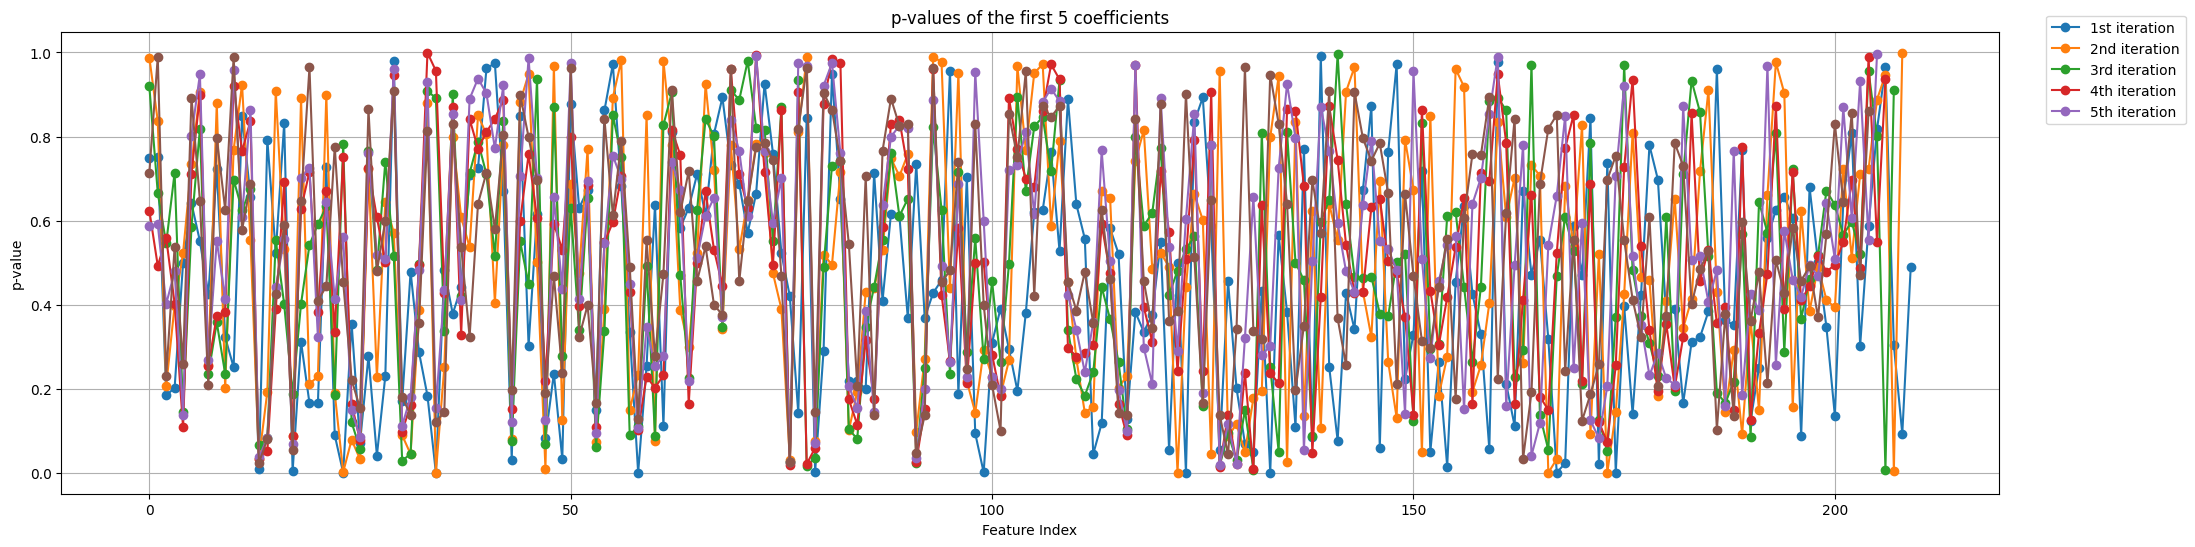

selected features: [58, 123, 208, 133, 129, 13, 77, 92]
best p-values: [2.5821478807146607e-37, 2.4993832786311215e-13, 0.006896839388985179, 0.007958283685032238, 0.01865329335145193, 0.02412528854979209, 0.03595807192750891, 0.035412722951125276]


In [692]:
selected_features, best_p_values = fvs(
    X_train_scaled.copy(), y_train_scaled.copy(), plot=True
)

best_p_values = [x[0] for x in best_p_values]

print("selected features:", selected_features)
print("best p-values:", best_p_values)

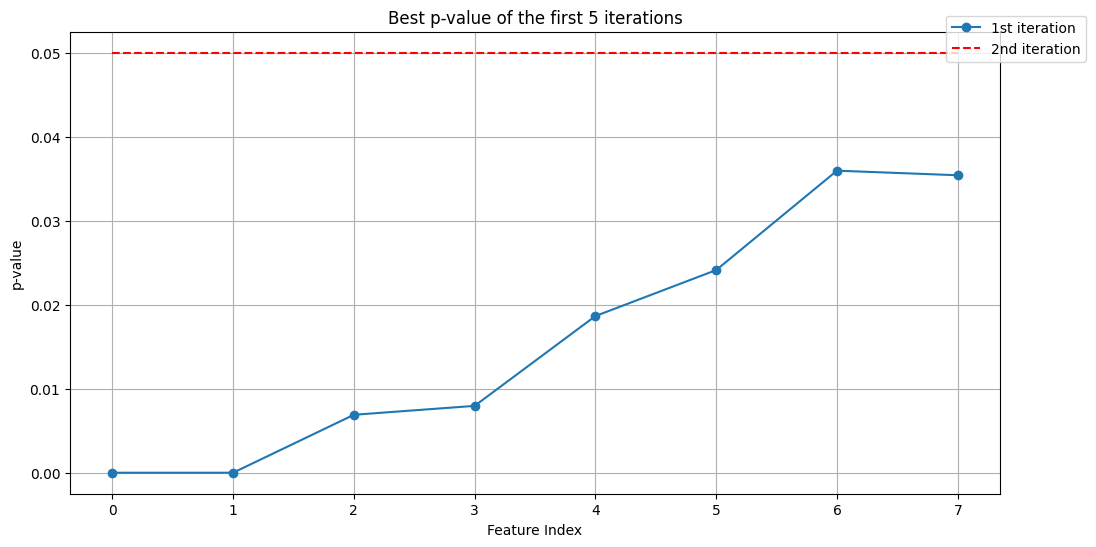

In [693]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(best_p_values)), best_p_values, marker="o", linestyle="-")
plt.plot(
    range(len(best_p_values)), [0.05] * len(best_p_values), linestyle="--", color="red"
)
plt.xlabel("Feature Index")
plt.ylabel("p-value")
plt.title("Best p-value of the first 5 iterations")
plt.grid(True)
plt.legend(
    [
        "1st iteration",
        "2nd iteration",
        "3rd iteration",
        "4th iteration",
        "5th iteration",
    ],
    loc="upper right",
    bbox_to_anchor=(1.1, 1.05),
)
plt.show()

## Q.4:


Run ridge regression using scikit-learn on the training set. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $10^{-1}$ and $10^6$. Display two subplots at the end:

- (a): The first subplot should show the evolution of the coefficients for each different value of the penalty parameter.
- (b): The second subplot should display the evolution of the R-squared coefficient at each of the 30 iterations.

Since we are going to perform similar tasks for Lasso and Elastic Net, it is mandatory to write this code as an independent function that can be parameterized for each specific case.


In [694]:
# We suppose to have standardized data
def run_custom_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    model,
    n_values,
    min_interval,
    max_interval,
):
    alphas = np.logspace(min_interval, max_interval, n_values)

    R2s = []
    coefs = []
    best_alpha = None

    for alpha in alphas:
        model.set_params(alpha=alpha)
        model.fit(X_train, y_train)
        coefs.append(model.coef_)

        y_pred = model.predict(X_test)

        # save the best alpha for later
        if (best_alpha is None) or (R2(y_test, y_pred) > max(R2s)):
            best_alpha = alpha

        R2s.append(R2(y_test, y_pred))

    if coefs[0].shape[0] == 1:
        coefs = [coef.reshape(-1) for coef in coefs]

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].set_title(
        "Evolution of the coefficients for each different value of the penalty parameter"
    )
    axs[0].plot(alphas, coefs)
    axs[0].set_xscale("log")
    axs[0].set_xlabel("Penalty parameter (alpha)")
    axs[0].set_ylabel("coefficients")
    axs[1].set_title(
        "Evolution of the R-squared coefficient for each different value of the penalty parameter"
    )
    axs[1].plot(alphas, R2s, marker="o")
    axs[1].set_xscale("log")
    axs[1].set_xlabel("Penalty parameter (alpha)")
    axs[1].set_ylabel("R-squared coefficient")

    plt.grid(True)
    plt.show()

    return best_alpha

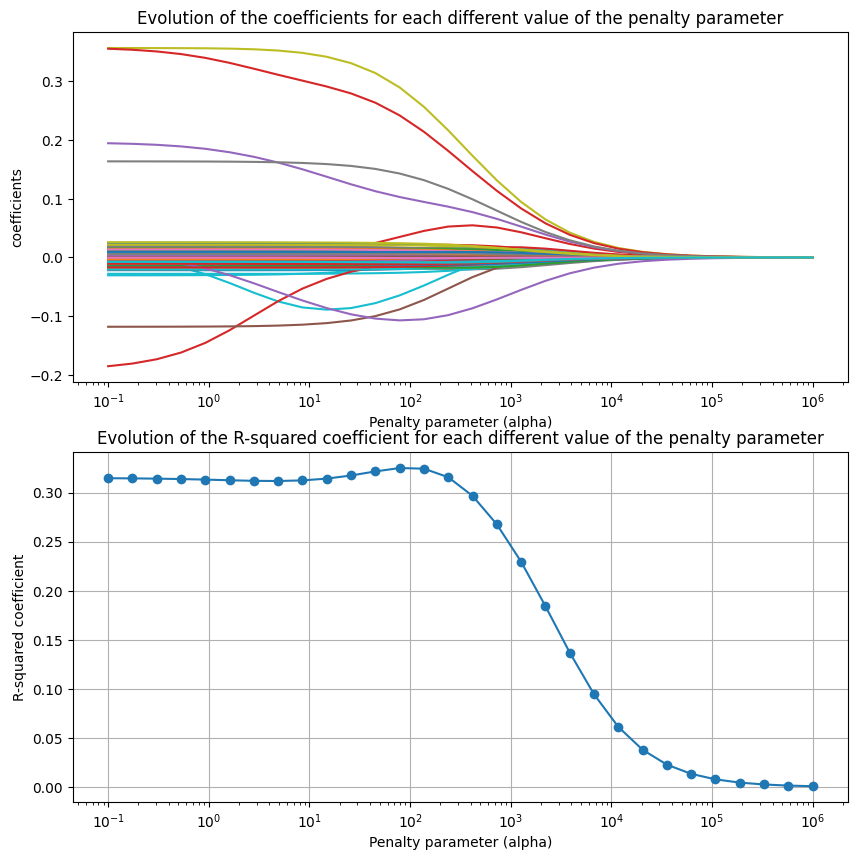

In [695]:
best_ridge = run_custom_regression(
    X_train_scaled,
    y_train_scaled,
    X_test_scaled,
    y_test_scaled,
    Ridge(),
    n_values=30,
    min_interval=-1,
    max_interval=6,
)

## Q.5:

Run the code for Lasso as explained in Point 4. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $10^{-3}$ and $10^2$.


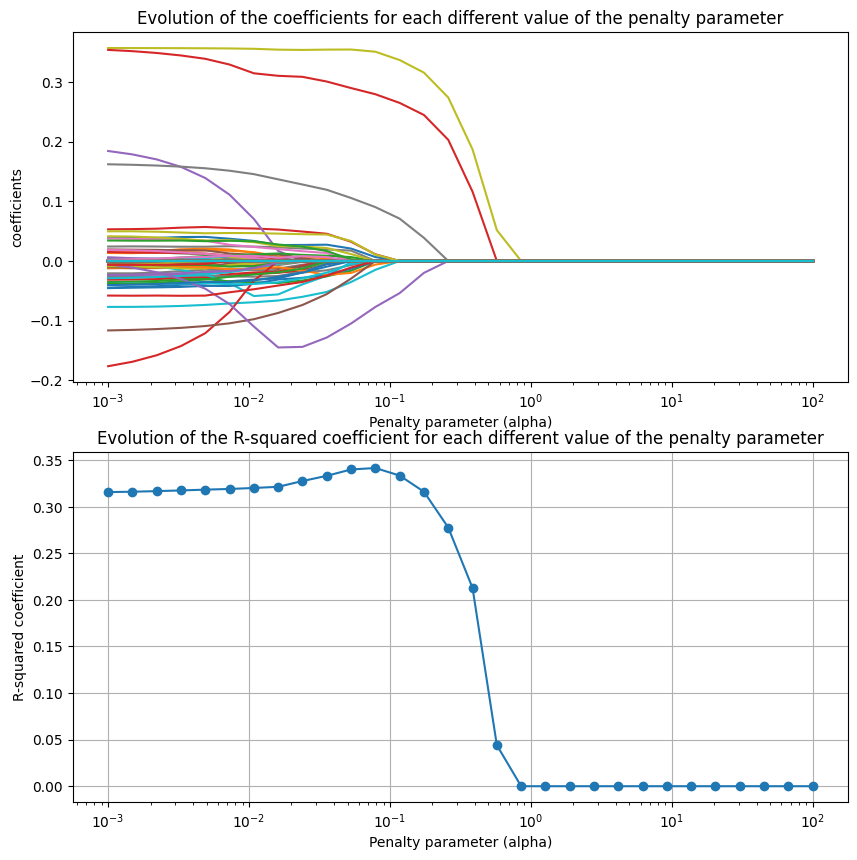

In [696]:
best_lasso = run_custom_regression(
    X_train_scaled,
    y_train_scaled,
    X_test_scaled,
    y_test_scaled,
    Lasso(),
    n_values=30,
    min_interval=-3,
    max_interval=2,
)

## Q.6:

Run the code for ElasticNet as explained in Point 4. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between $10^{-3}$ and $10^2$.


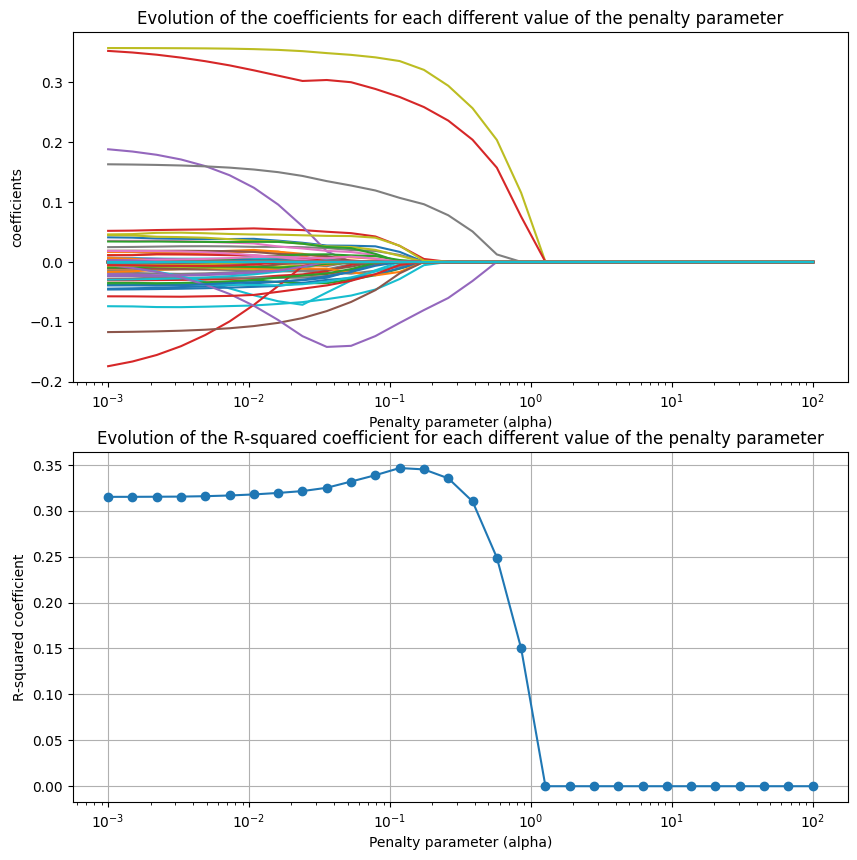

In [697]:
best_elastic = run_custom_regression(
    X_train_scaled,
    y_train_scaled,
    X_test_scaled,
    y_test_scaled,
    ElasticNet(),
    n_values=30,
    min_interval=-3,
    max_interval=2,
)

## Q.7:

Compute the singular value decomposition of the covariance matrix. For consistency in the notation use $U, s, V = SVD(X^{T}X)$.


In [698]:
N = X_train_scaled.shape[0]
cov = np.dot(X_train_scaled.T, X_train_scaled) / (N - 1)
U, s, Ut = np.linalg.svd(cov)

#### (a):

Plot a heatmap of the covariance matrix.


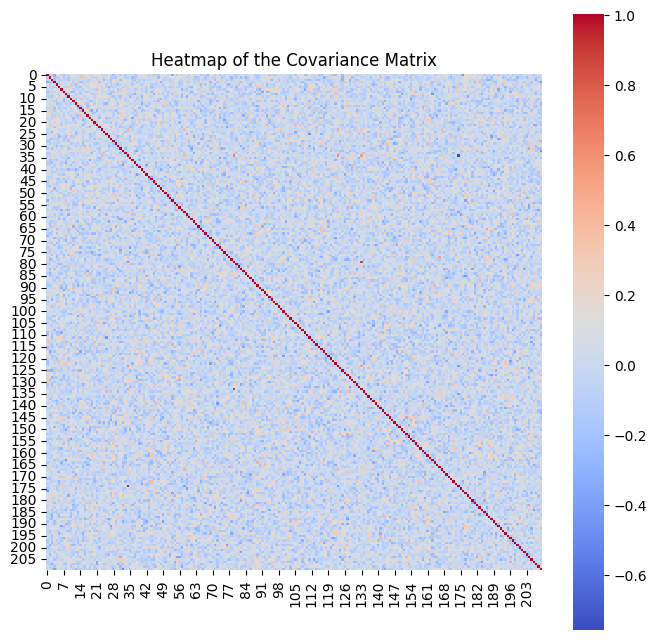

In [699]:
plt.figure(figsize=(8, 8))
sns.heatmap(cov, cmap="coolwarm", square=True)
plt.title("Heatmap of the Covariance Matrix")
plt.show()

#### (b):

Compute PCA for the data using SVD.


In [700]:
# returns the projection of X on the first n_components principal components and the principal components
def PCA(X, n_components):
    N = X.shape[0]
    cov = np.dot(X.T, X) / (N - 1)
    U, s, Vt = np.linalg.svd(cov)

    return X @ U.T[:, :n_components], U.T[:, :n_components]


X_train_pca, pc_3 = PCA(X_train_scaled, 3)

#### (c):

Plot the amount of variance explained by the first $k$ components for $k \in 2..p$.How many variables do we need to explain more than $90%$ of the variance?


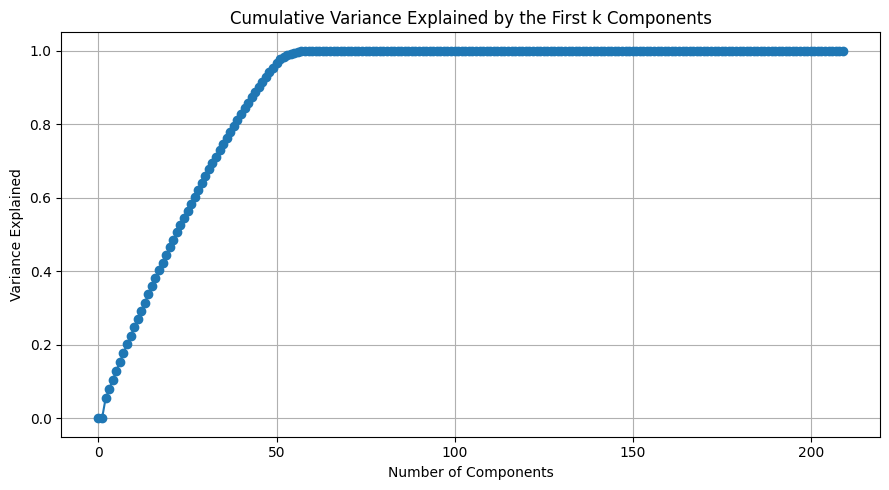

In [701]:
def compute_explained_variance(s):
    explained_variance = np.zeros(s.shape[0])

    for i in range(2, len(s)):
        explained_variance[i] = np.sum(s[:i]) / np.sum(s)

    return explained_variance


explained_variance = compute_explained_variance(s)

plt.figure(figsize=(9, 5))
plt.title("Cumulative Variance Explained by the First k Components")
plt.plot(explained_variance, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

In [702]:
n_components = np.where(explained_variance > 0.9)[0][0]
print("Number of components to explain more than 90% of the variance:", n_components)

Number of components to explain more than 90% of the variance: 45


As we can see in the graph we need around 50 variables to explain more than 90% of the variance.

#### (d):

Plot the projected data with $k = 2$ using as color the value of $y$ and interpret the plot.


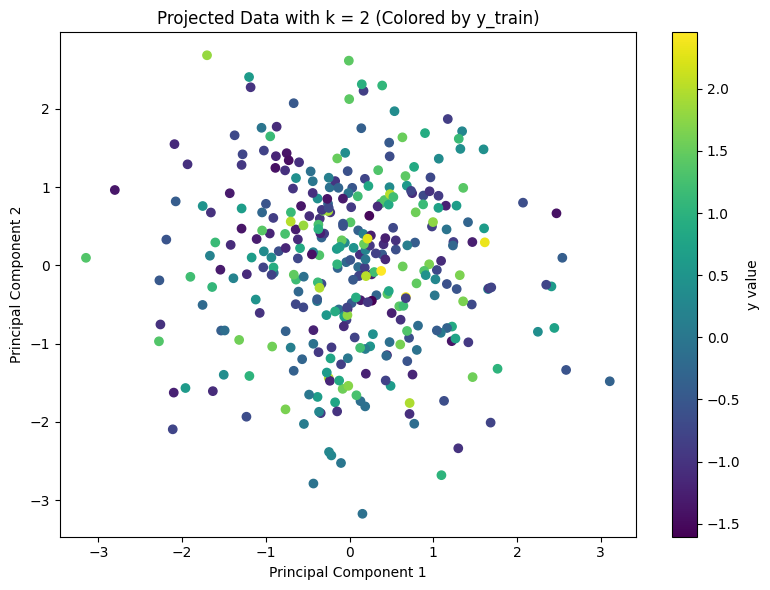

In [703]:
X_train_pca, pc_2 = PCA(X_train_scaled, 2)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_scaled, cmap="viridis")
plt.title("Projected Data with k = 2 (Colored by y_train)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="y value")
plt.tight_layout()
plt.show()

#### (e):

Plot the the two first principal directions.


In [704]:
inner_product = np.dot(pc_2[:, 0], pc_2[:, 1])

print("Inner product between the first two principal components:", inner_product)

if np.isclose(inner_product, 0):
    print("Principal components are approximately orthogonal.")
else:
    print("Principal components are not orthogonal.")

Inner product between the first two principal components: -1.9992688060632702e-16
Principal components are approximately orthogonal.


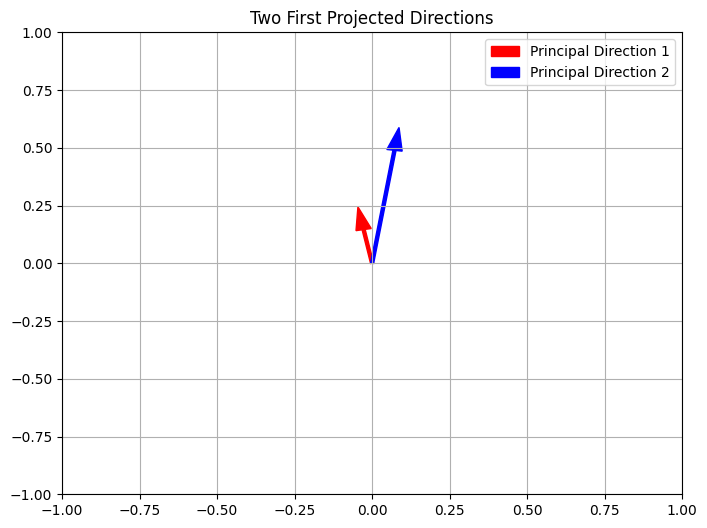

In [705]:
plt.figure(figsize=(8, 6))

for i in range(2):
    fc = "red" if i == 0 else "blue"
    ec = "red" if i == 0 else "blue"

    plt.arrow(
        0,
        0,
        5 * Ut[0, i],
        5 * Ut[1, i],
        head_width=0.05,
        head_length=0.1,
        width=0.01,
        fc=fc,
        ec=ec,
        label=f"Principal Direction {i + 1}",
    )

plt.title("Two First Projected Directions")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid(True)
plt.legend()
plt.show()

#### (f):

Run OLS on the projected data (PCR) using $k$ components for $k \lt 50$. Select the $k$ that returns the best score of the OLS model and plot the evolution of the scores with $k$.


Best k: 49
Best score: 0.22550721730575574


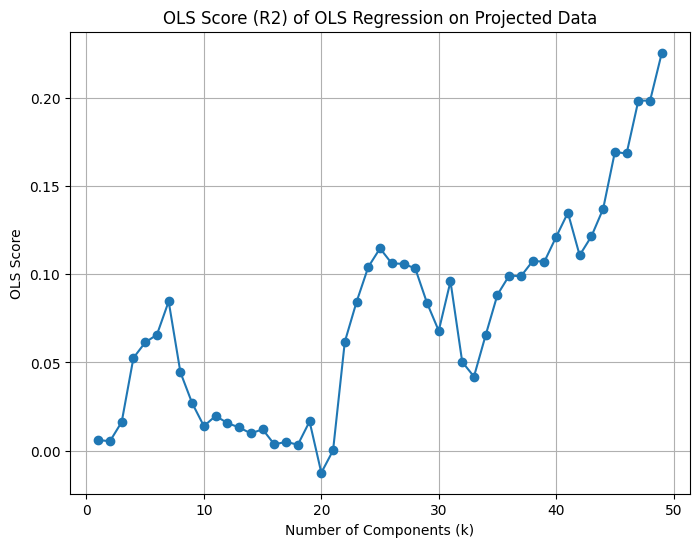

In [706]:
OLS_score = []

for k in range(1, min(X_train.shape[1], 50)):
    X_train_pca, pc_k = PCA(X_train_scaled, k)
    X_test_pca = X_test_scaled @ pc_k

    OLS = LinearRegression().fit(X_train_pca, y_train_scaled)
    OLS_score.append(OLS.score(X_test_pca, y_test_scaled))

best_k = np.argmax(OLS_score) + 1
best_score = np.max(OLS_score)

print("Best k:", best_k)
print("Best score:", best_score)

plt.figure(figsize=(8, 6))
plt.title("OLS Score (R2) of OLS Regression on Projected Data")
plt.plot(range(1, 50), OLS_score, marker="o")
plt.xlabel("Number of Components (k)")
plt.ylabel("OLS Score")
plt.grid(True)
plt.show()

## Q.8:

Summarize the results of the models and elaborate in their main characteristics. Plot all the training and testing errors for all the models considered and elaborate on the results.


          LinearRegression Ridge (alpha=78.80) Lasso (alpha=0.08)  \
MSE_train         0.429143            0.392197            0.47158   
MSE_test          0.672812            0.535712           0.522562   
R2_test           0.152485            0.325185            0.34175   
R2_train          0.570857            0.607803            0.52842   

          ElasticNet (alpha=0.12) Forward Variable Selection  \
MSE_train                0.448599                   0.441517   
MSE_test                 0.518738                   0.610085   
R2_test                  0.346566                     0.2315   
R2_train                 0.551401                   0.558483   

          PCA regression k=49  
MSE_train            0.439978  
MSE_test             0.614843  
R2_test              0.225507  
R2_train             0.560022  


<Figure size 2500x600 with 0 Axes>

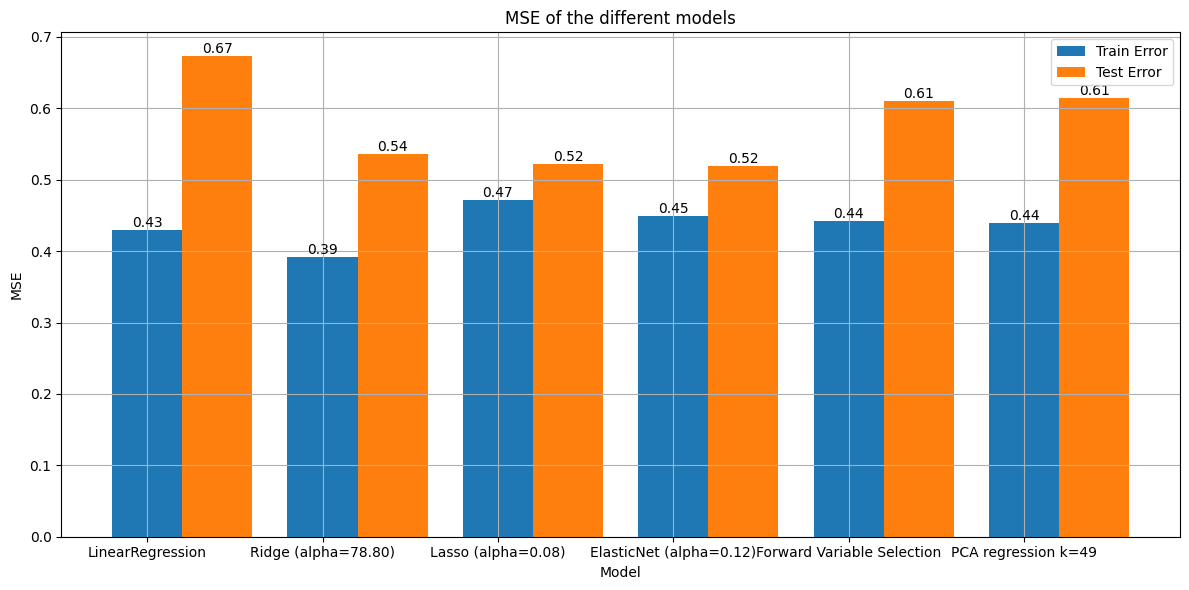

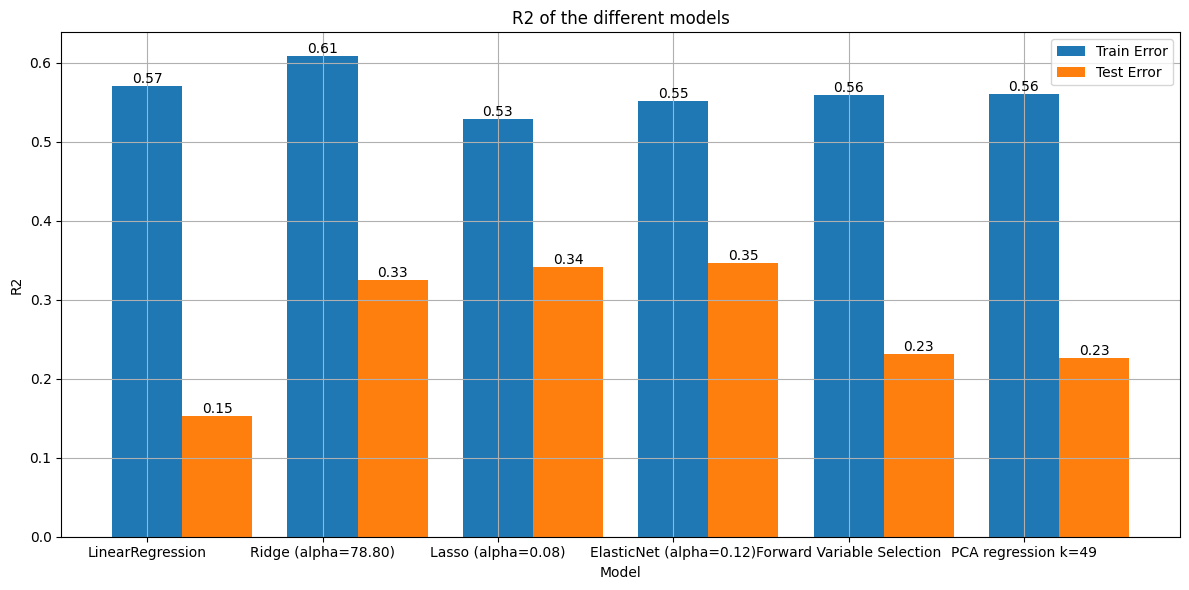

In [707]:
models = [LinearRegression, Ridge, Lasso, ElasticNet]
best_alphas = [None, best_ridge, best_lasso, best_elastic]

MSE_train_errors = []
MSE_test_errors = []

R2_train_errors = []
R2_test_errors = []

headers = []

for model, best_alpha in zip(models, best_alphas):
    if best_alpha is None:
        headers += [model.__name__]
    else:
        headers += [model.__name__ + f" (alpha={best_alpha:.2f})"]

    if best_alpha is None:
        model = model()
    else:
        model = model(alpha=best_alpha)

    model.fit(X_train_scaled, y_train_scaled)

    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    MSE_train_errors.append(MSE(y_train_scaled, y_pred_train))
    MSE_test_errors.append(MSE(y_test_scaled, y_pred_test))
    R2_train_errors.append(R2(y_train_scaled, y_pred_train))
    R2_test_errors.append(R2(y_test_scaled, y_pred_test))

# forward variable selection
selected_features, best_p_values = fvs(X_train_scaled.copy(), y_train_scaled.copy())

model = LinearRegression(fit_intercept=False)
model.fit(X_train_scaled[:, selected_features], y_train_scaled)

y_pred_train = model.predict(X_train_scaled[:, selected_features])
y_pred_test = model.predict(X_test_scaled[:, selected_features])

MSE_train_errors.append(MSE(y_train_scaled, y_pred_train))
MSE_test_errors.append(MSE(y_test_scaled, y_pred_test))
R2_train_errors.append(R2(y_train_scaled, y_pred_train))
R2_test_errors.append(R2(y_test_scaled, y_pred_test))

headers.append("Forward Variable Selection")

# PCA regression with best k
X_train_pca, pc_k = PCA(X_train_scaled, best_k)
X_test_pca = X_test_scaled @ pc_k

model = LinearRegression(fit_intercept=False)
model.fit(X_train_pca, y_train_scaled)

y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)

MSE_train_errors.append(MSE(y_train_scaled, y_pred_train))
MSE_test_errors.append(MSE(y_test_scaled, y_pred_test))
R2_train_errors.append(R2(y_train_scaled, y_pred_train))
R2_test_errors.append(R2(y_test_scaled, y_pred_test))

headers.append(f"PCA regression k={best_k}")

df_errors = pd.DataFrame(
    index=["MSE_train", "MSE_test", "R2_test", "R2_train"],
    columns=headers,
)

df_errors.loc["MSE_train", :] = MSE_train_errors
df_errors.loc["MSE_test", :] = MSE_test_errors
df_errors.loc["R2_train", :] = R2_train_errors
df_errors.loc["R2_test", :] = R2_test_errors

print(df_errors)

plt.figure(figsize=(12, 6))
plt.title("MSE of the different models")
plt.bar_label(
    plt.bar(
        range(len(models) + 2),
        MSE_train_errors,
        width=0.4,
        label="Train Error",
    ),
    fmt="%.2f",
)
plt.bar_label(
    plt.bar(
        np.array(range(len(models) + 2)) + 0.4,
        MSE_test_errors,
        width=0.4,
        label="Test Error",
    ),
    fmt="%.2f",
)
plt.xticks(range(len(models) + 2), headers)
plt.xlabel("Model")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.title("R2 of the different models")
plt.bar_label(
    plt.bar(
        range(len(models) + 2),
        R2_train_errors,
        width=0.4,
        label="Train Error",
    ),
    fmt="%.2f",
)
plt.bar_label(
    plt.bar(
        np.array(range(len(models) + 2)) + 0.4,
        R2_test_errors,
        width=0.4,
        label="Test Error",
    ),
    fmt="%.2f",
)
plt.xticks(range(len(models) + 2), headers)
plt.xlabel("Model")
plt.ylabel("R2")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

Brief summary of the models:

- *OLS*: The OLS model is the simplest one. It is the one that overfits the most. This is because it is the model that has the highest variance. This is due to the fact that it does not have any regularization term.

- *Ridge*: This model has a regularization term. This regularization term penalizes the model for having high coefficients. This is why the coefficients of the Ridge model are lower than the ones of the OLS model. However, this regularization term does not penalize the model for having too many coefficients. This is why the Ridge model has a higher bias than the OLS model.

- *Lasso*: The Lasso model, like Ridge, incorporates a regularization term, but with a key difference. Lasso's regularization term not only penalizes large coefficients but also encourages sparsity by pushing some coefficients to exactly zero. This sparsity-inducing property makes Lasso effective for feature selection, as it tends to select a subset of the most relevant features. However, Lasso's bias is higher compared to OLS due to the feature selection, and it strikes a balance between variance reduction and model simplicity.

- *ElasticNet*: ElasticNet combines both Lasso and Ridge regularization terms. It includes a penalty term for large coefficients (similar to Ridge) and a sparsity-inducing term (similar to Lasso). The advantage of ElasticNet is that it addresses some limitations of Lasso when faced with highly correlated features by still allowing some degree of grouping. This model strikes a balance between the bias-variance trade-off, offering a more flexible regularization approach than Ridge or Lasso alone.

In our case the best model is ElasticNet with $\alpha = 0.12$. We can see that it maximises the $R^2$ coefficient and minimizes the MSE.